In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 1. Use retina for crisp, PDF-like text that never disappears in HTML
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# 2. Set a high baseline DPI
plt.rcParams["figure.dpi"] = 150

# FID - Zero Filling

In Magnetic Resonance, **zero filling** involves artificially extending a dataset in the time domain (FID) or spatial-frequency domain (k-space) by padding it with zeros.

### The Physics of Zero Filling
While it is often mistaken for increasing "true" resolution, zero filling does **not** add new information. According to the Fourier Shift Theorem and DFT properties:

1.  **In MRS (Time Domain):** Padding the end of an FID with zeros increases the number of points in the spectrum. This acts as a **sinc interpolation**, improving the **digital resolution** ($ \Delta f = 1/T_{acq} $) and allowing us to better visualize the true peak shape and position.
2.  **In MRI (k-space):** Symmetrically padding the edges of k-space decreases the pixel size in the reconstructed image. This reduces **truncation artifacts** (Gibbs ringing)  by smoothly interpolating values between the original coarse pixels.

---

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import xmris

## 1. Generating a Realistic FID: Sampled Data
Let's define a function to simulate a multi-component FID with $T_2^*$ decay and specific frequency offsets.

In [3]:
def simulate_fid(t):
    """Simulate a 3-peak FID (doublet + singlet) given a time array."""
    peak1 = 1.0 * np.exp(-t / 0.05) * np.exp(1j * 2 * np.pi * 50 * t)
    peak2 = 0.5 * np.exp(-t / 0.03) * np.exp(1j * 2 * np.pi * 30 * t)
    peak3 = 0.5 * np.exp(-t / 0.03) * np.exp(1j * 2 * np.pi * 70 * t)
    return peak1 + peak2 + peak3

We will simulate a realistic **Sampled** dataset with finite bandwidth.

*(Note: Dwell time must be small enough to satisfy the Nyquist criterion. A 5 ms dwell time yields a 200 Hz bandwidth (±100 Hz), safely capturing our 70 Hz peak without aliasing).*

In [4]:
# Generate realistically Sampled data
dwell_time = 0.002
bw_sampled = 1 / dwell_time  # 200 Hz
n_points_sampled = 128
t_sampled = np.arange(n_points_sampled) * dwell_time

da_fid_sampled = xr.DataArray(
    simulate_fid(t_sampled),
    dims=["Time"],
    coords={"Time": t_sampled},
    attrs={"sequence": "FID", "B0": 3.0},
)

## 2. Time-Domain Zero Filling
We apply zero filling to the sampled data, extending it from 64 points to 512 points by padding zeros at the end of the acquisition window.

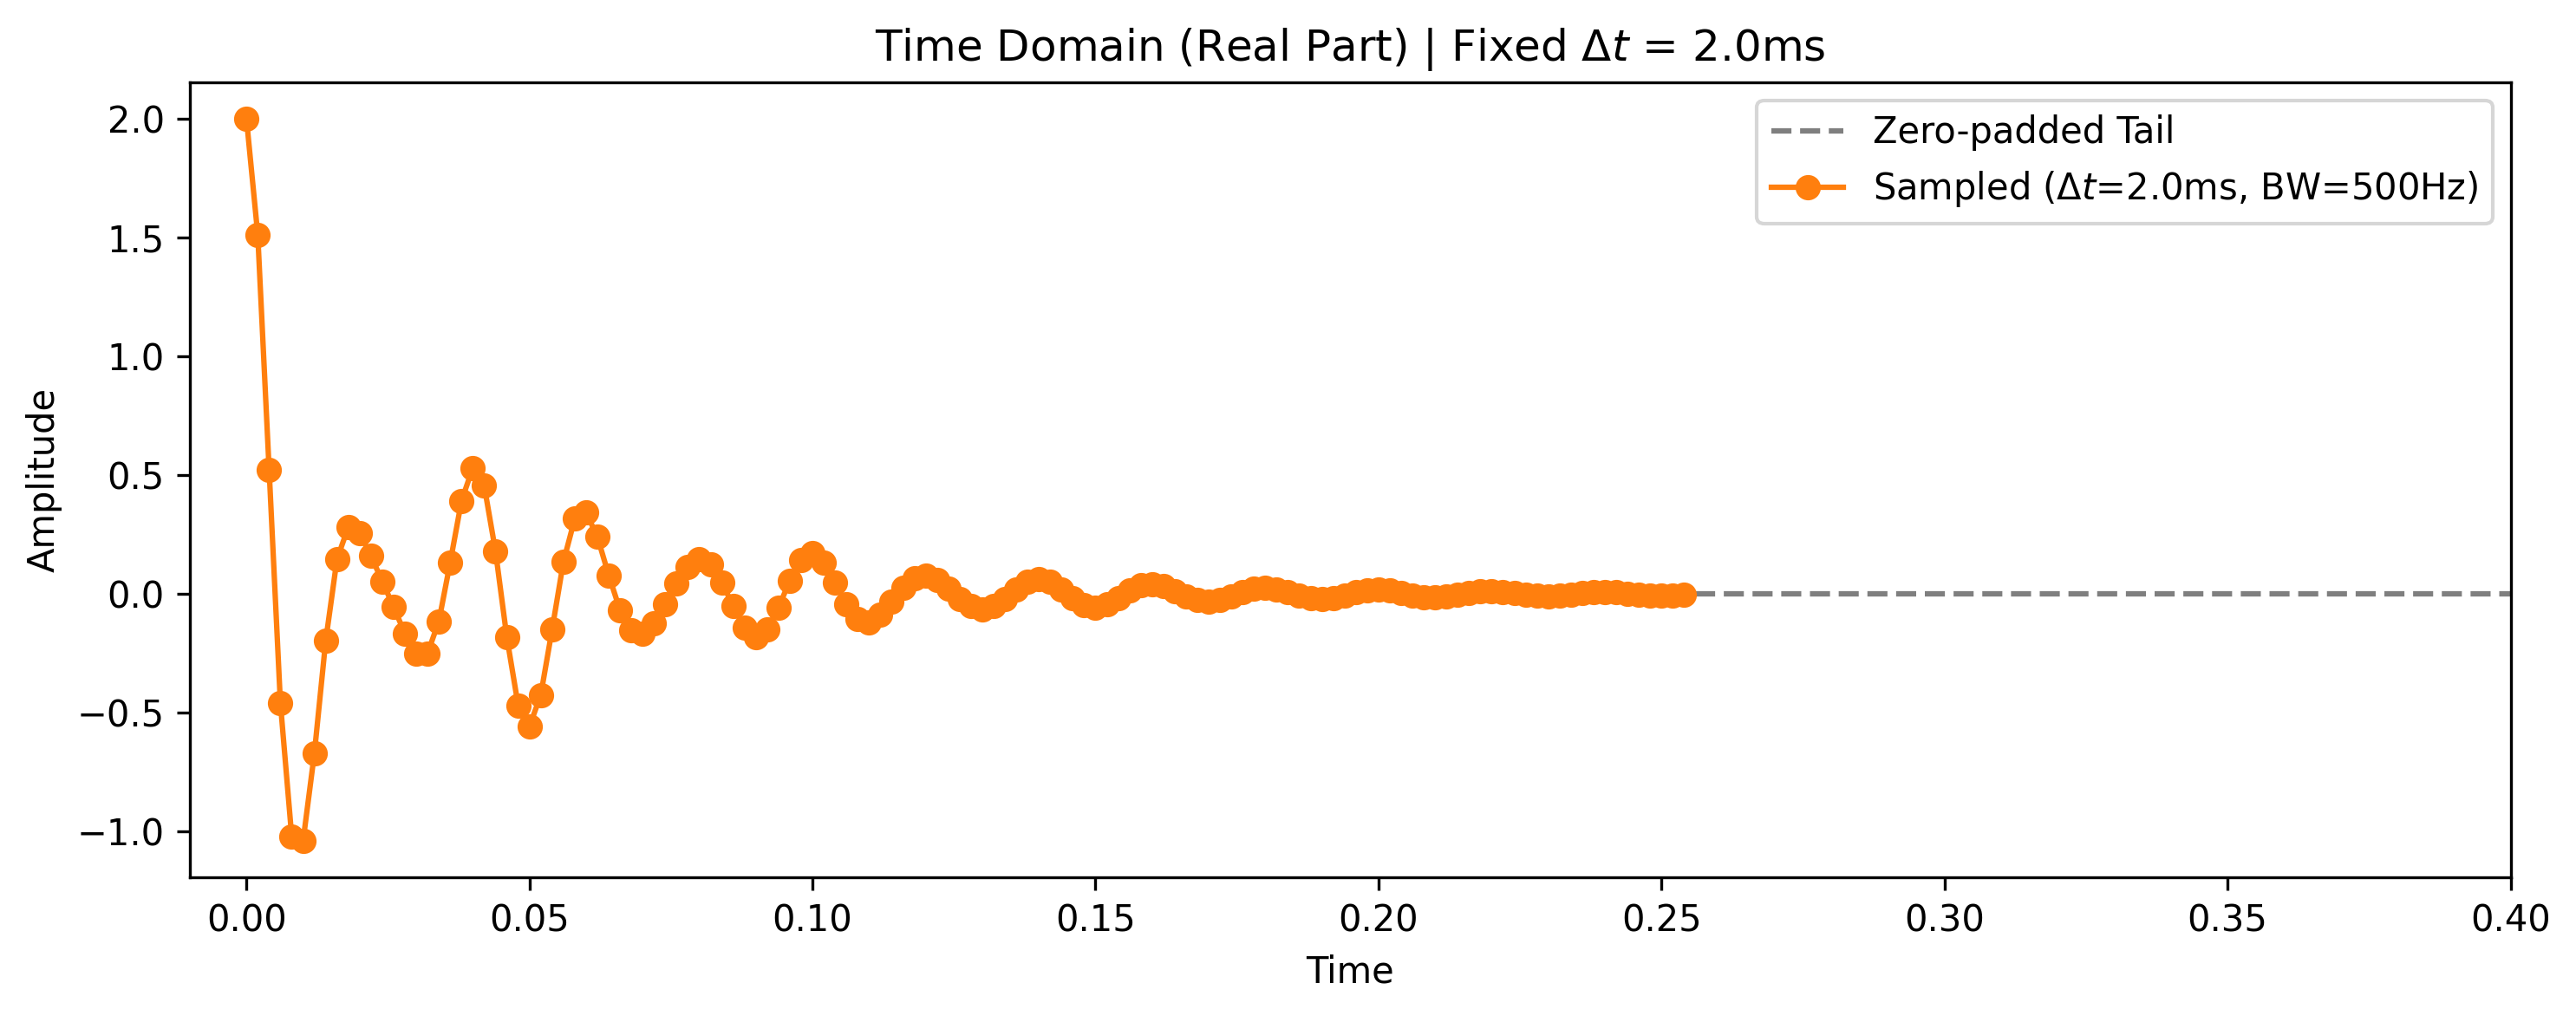

In [5]:
target_points = n_points_sampled * 8  # 512 points

# Zero fill the sampled array
da_fid_zf = da_fid_sampled.xmr.zero_fill(
    dim="Time", target_points=target_points, position="end"
)

fig, ax1 = plt.subplots(figsize=(10, 4))

# Zero-filled tail
da_fid_zf.isel(Time=slice(n_points_sampled, target_points)).real.plot(
    ax=ax1, color="black", linestyle="--", alpha=0.5, label="Zero-padded Tail"
)
# Original Sampled Points
da_fid_sampled.real.plot(
    ax=ax1,
    marker="o",
    color="tab:orange",
    linestyle="-",  # Connected to show the original signal path
    label=f"Sampled ($\Delta t$={dwell_time * 1000:.1f}ms, BW={bw_sampled:.0f}Hz)",
)

ax1.set_xlim(-0.01, 0.4)
ax1.set_title(f"Time Domain (Real Part) | Fixed $\Delta t$ = {dwell_time * 1000:.1f}ms")
ax1.set_ylabel("Amplitude")
ax1.legend()

plt.tight_layout()
plt.show()

### Interpolating the Truth (Frequency Domain)
When we transform the zero-filled data, the zeros act as mathematical anchors, forcing the FFT to interpolate the discrete points, resulting in a much smoother spectrum.

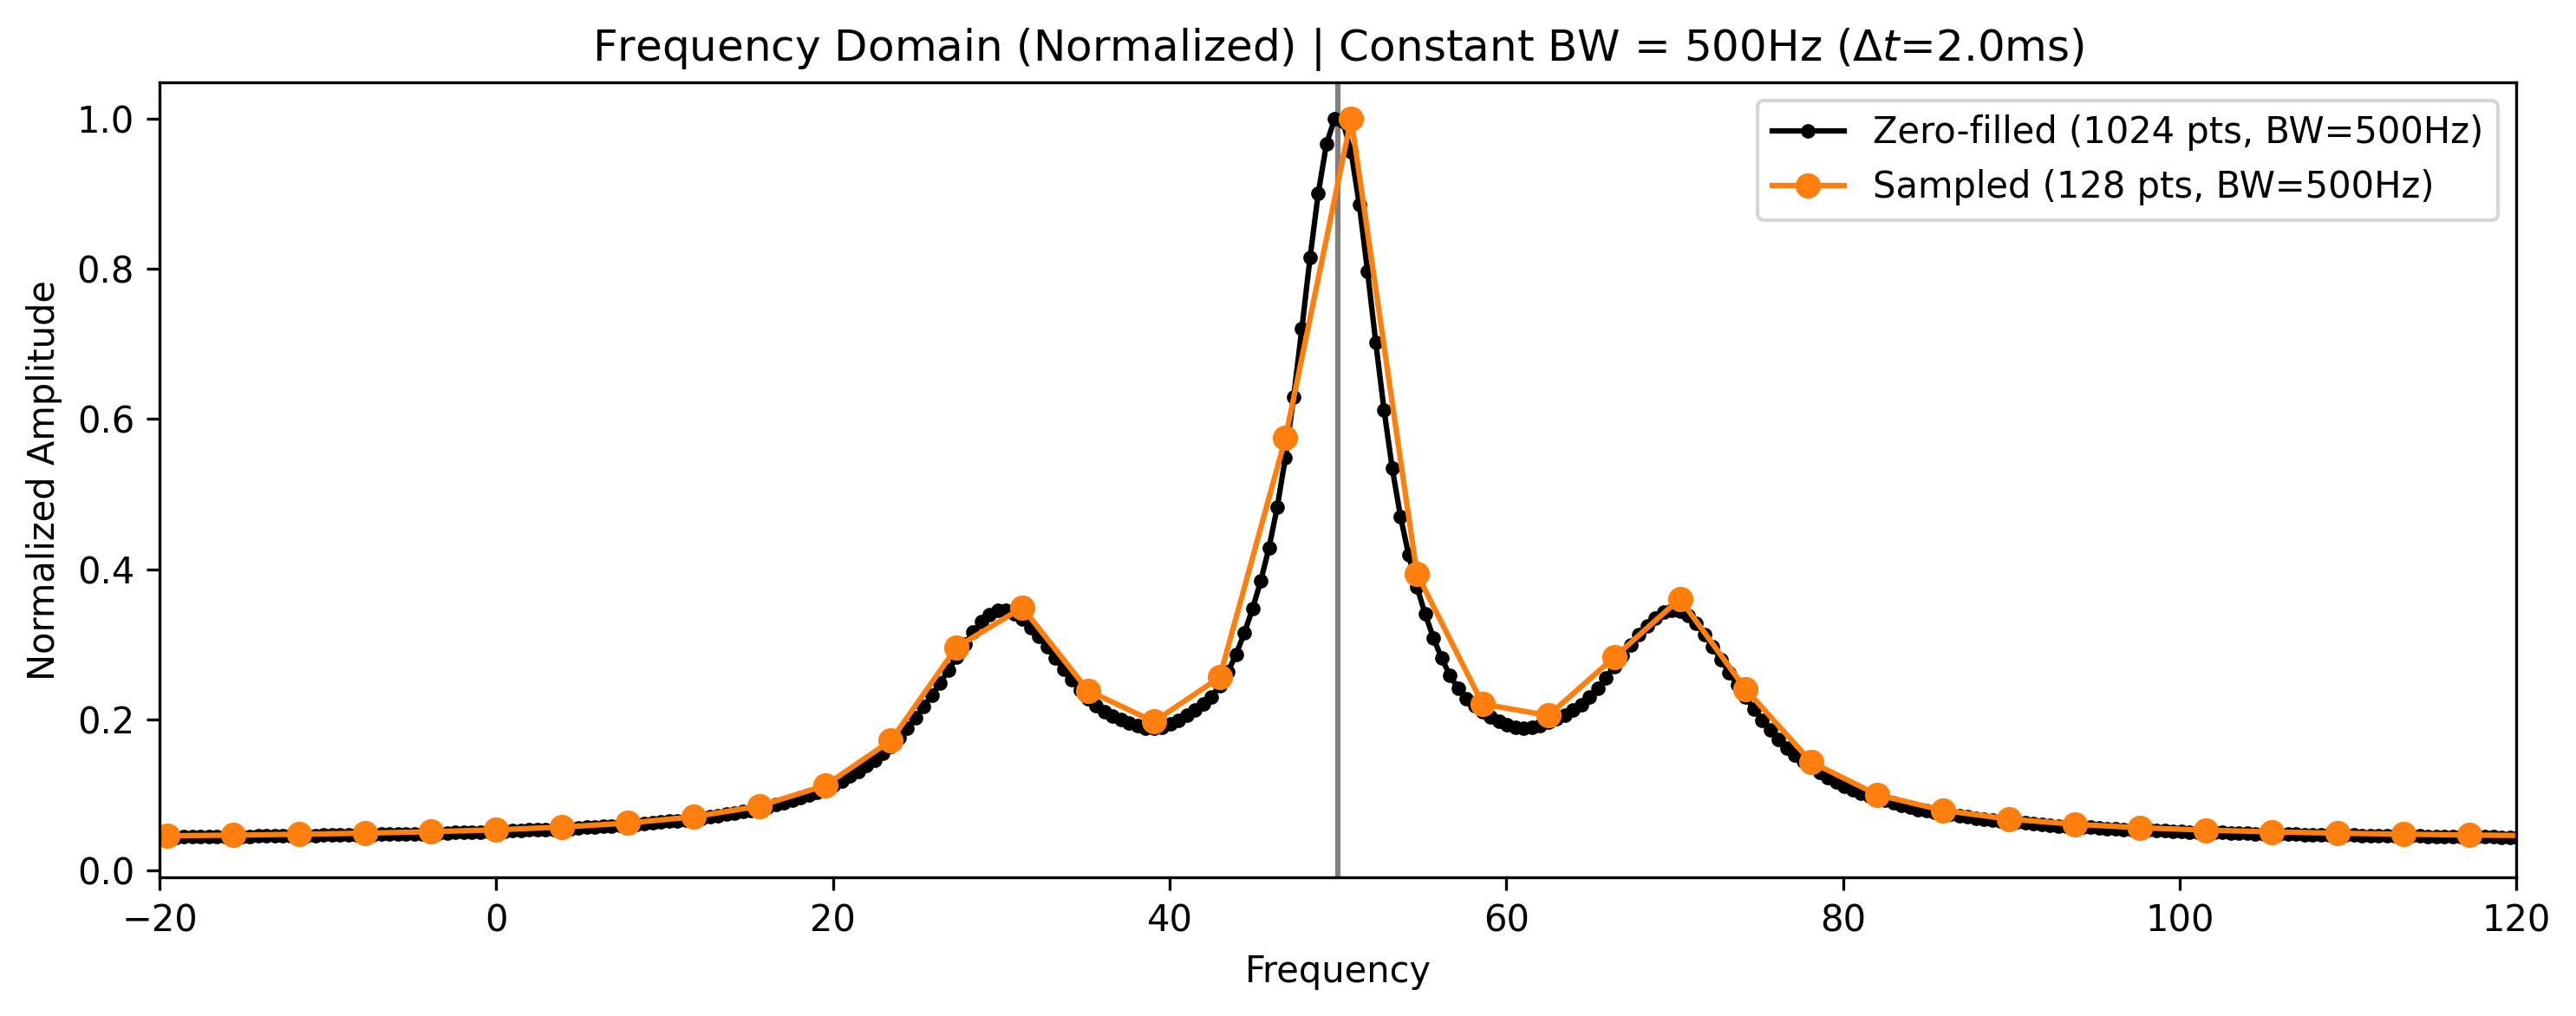

In [6]:
fig, ax2 = plt.subplots(figsize=(10, 4))

spec_sampled = da_fid_sampled.xmr.to_spectrum().real
spec_zf = da_fid_zf.xmr.to_spectrum().real

# Normalize spectra to their maximum value (peak height = 1.0)
spec_sampled_norm = spec_sampled / spec_sampled.max()
spec_zf_norm = spec_zf / spec_zf.max()

# Zero-filled Interpolation
spec_zf_norm.plot(
    ax=ax2,
    color="black",
    marker=".",
    linewidth=1.5,
    label=f"Zero-filled ({target_points} pts, BW={bw_sampled:.0f}Hz)",
)
# Original Sampled Points
spec_sampled_norm.plot(
    ax=ax2,
    marker="o",
    markersize=6,
    color="tab:orange",
    label=f"Sampled ({n_points_sampled} pts, BW={bw_sampled:.0f}Hz)",
)

cf = 50  # centerfreq
ax2.set_xlim(cf - 70, cf + 70)
ax2.axvline(cf, color="gray", zorder=-10)
ax2.set_title(
    f"Frequency Domain (Normalized) | Constant BW = {bw_sampled:.0f}Hz ($\Delta t$={dwell_time * 1000:.1f}ms)"
)
ax2.set_ylabel("Normalized Amplitude")
ax2.legend()


plt.tight_layout()
plt.show()

---
## 3. Spatial Frequency Zero Filling (2D K-Space)

In MRI imaging, we zero-fill k-space to artificially boost the digital resolution matrix (e.g., from 32x32 to 128x128).

In [7]:
# Create a low-res 32x32 k-space grid
N = 32
k_vec = np.linspace(-N // 2, N // 2 - 1, N)
kx, ky = np.meshgrid(k_vec, k_vec)

# Physics: A rectangular object in image space is a 2D sinc in k-space
kspace_2d = np.sinc(kx / 6) * np.sinc(ky / 6)
da_k2d = xr.DataArray(
    kspace_2d + 0j, dims=["ky", "kx"], coords={"ky": k_vec, "kx": k_vec}
)

# Symmetrically Zero-fill to 128x128
da_k2d_zf = da_k2d.xmr.zero_fill(dim="kx", target_points=128, position="symmetric")
da_k2d_zf = da_k2d_zf.xmr.zero_fill(dim="ky", target_points=128, position="symmetric")

### Image Reconstruction
Transforming back to image space demonstrates how zero-filling smooths the blocky pixels of the low-resolution acquisition.

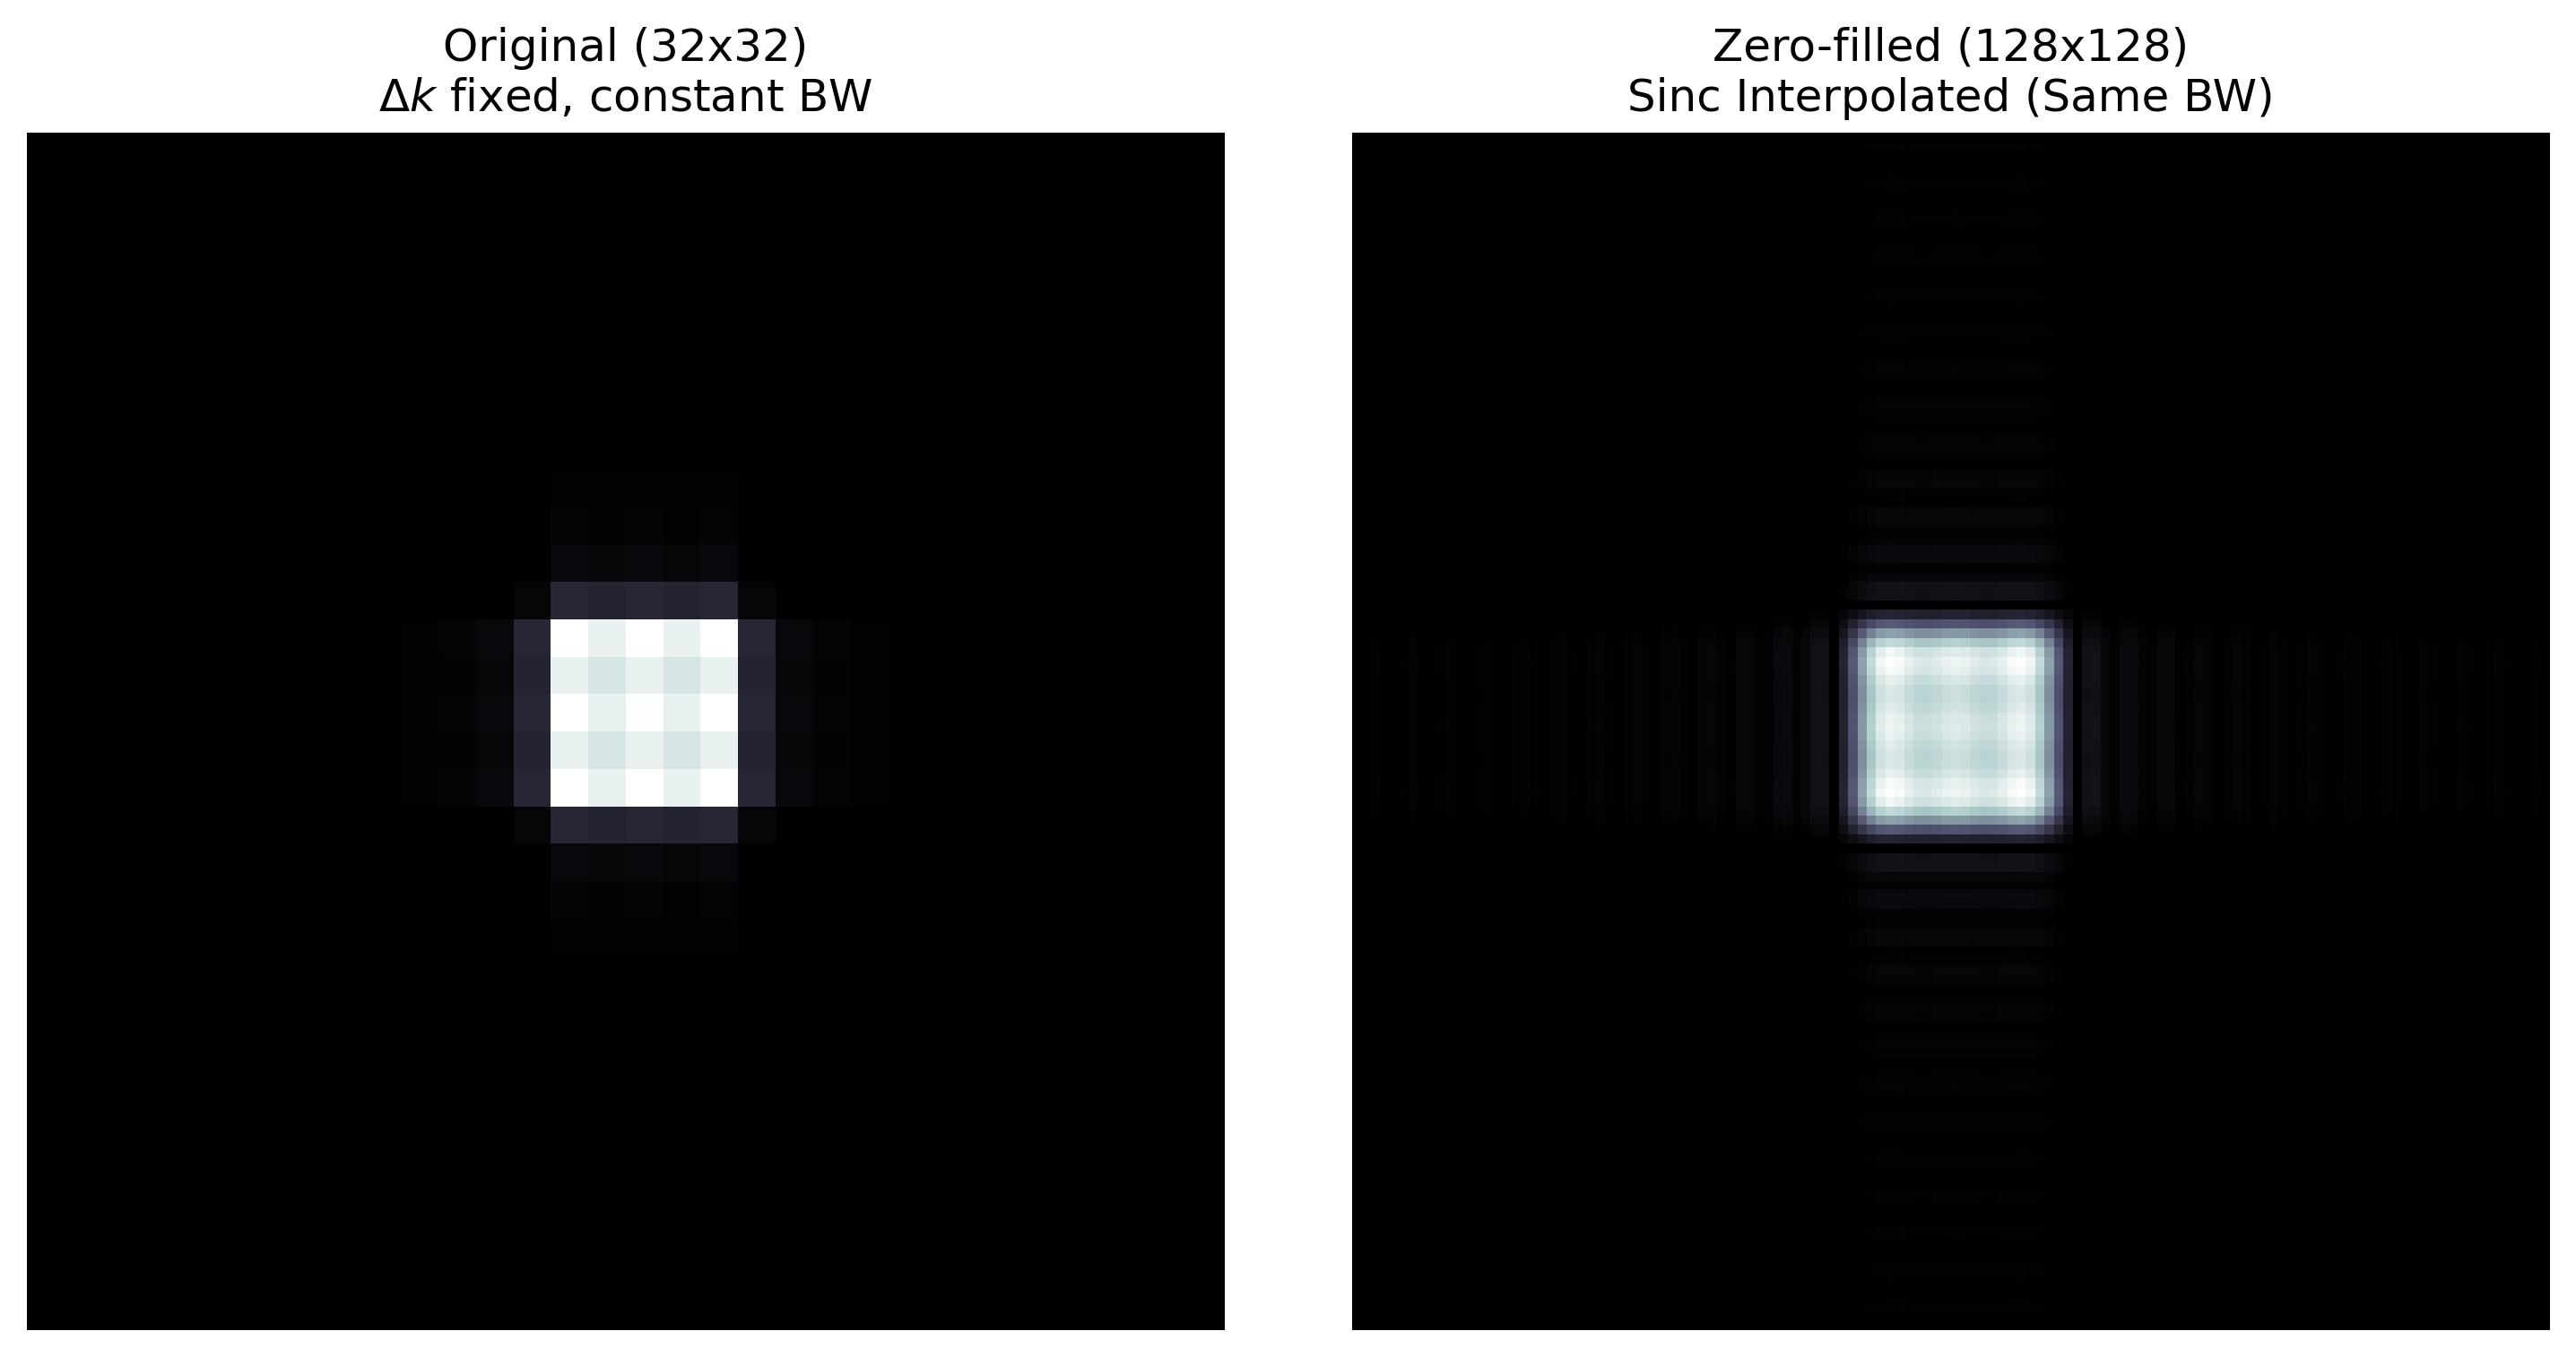

In [8]:
# Transform to image space
img_orig = np.abs(da_k2d.xmr.ifftc(dim=["kx", "ky"]))
img_zf = np.abs(da_k2d_zf.xmr.ifftc(dim=["kx", "ky"]))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_orig, cmap="bone", origin="lower")
axes[0].set_title(f"Original ({N}x{N})\n$\Delta k$ fixed, constant BW")

axes[1].imshow(img_zf, cmap="bone", origin="lower")
axes[1].set_title("Zero-filled (128x128)\nSinc Interpolated (Same BW)")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()